In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from multiprocessing import Pool
from pathlib import Path
import sys

# set path to the utils
notebook_dir = os.getcwd()
notebook_name = "check_generated_data.ipynb"

PATH = Path(notebook_dir) / Path(notebook_name) 

sys.path.insert(0, str(Path(*[i for i in PATH.parts[:PATH.parts.index("VIEWS_FAO_index")+1]]) / "src/utils"))   

from set_paths import setup_project_paths
setup_project_paths(PATH)

from utils_plotting import plot_time_series_data, plot_random_monthly_and_yearly_data
from utils_annual_aggregation import aggregate_monthly_to_yearly
from utils_feature_eng_per_100k import feature_eng_fat_per_100k
#from utils_cumulative_distribution import calculate_global_cumulative_distribution
from utils_global_probabilities import calculate_global_probabilities
from utils_country_probabilities import calculate_all_country_probabilities
from utils_return_periods import calculate_return_periods
from utils_check_expected_features import check_expected_features                                                                         

In [2]:
print(np.__version__) # 1.26.4 used
print(pd.__version__) # 2.2.1 used
print(matplotlib.__version__) # 3.8.4 used
print(sns.__version__) # 0.13.2 used

1.22.3
2.0.3
3.7.2
0.13.2


# Load data

In [3]:
def process_dataframes(path_df):
    """
    Process the dataframes by performing feature engineering, calculating probabilities,
    and calculating return periods.

    Parameters:
    path_df (str): Path to the DataFrame pickle file.
    columns (list): List of columns to process.

    Returns:
    tuple: Processed monthly and yearly DataFrames.
    """
    columns = ['sb_best', 'ns_best', 'os_best', 'total_best', 'fatalities_per_100k', 'sb_per_100k', 'ns_per_100k', 'os_per_100k']

    df_monthly = pd.read_pickle(path_df)
    df_yearly = aggregate_monthly_to_yearly(df_monthly)

    # Feature engineering
    df_monthly = feature_eng_fat_per_100k(df_monthly)
    df_yearly = feature_eng_fat_per_100k(df_yearly)

    # Calculate probabilities
    for col in columns:
        df_monthly = calculate_global_probabilities(df_monthly, col, 'month_id')
        df_yearly = calculate_global_probabilities(df_yearly, col, 'year_id')
        df_monthly = calculate_all_country_probabilities(df_monthly, col, 'month_id')
        df_yearly = calculate_all_country_probabilities(df_yearly, col, 'year_id')

    # Calculate return periods
    for col in columns:
        df_monthly = calculate_return_periods(df_monthly, f'{col}_unit_likelihood', f'{col}_time_unit_likelihood')
        df_monthly = calculate_return_periods(df_monthly, f'{col}_unit_likelihood_country', f'{col}_time_unit_likelihood_country')
        df_yearly = calculate_return_periods(df_yearly, f'{col}_unit_likelihood', f'{col}_time_unit_likelihood')
        df_yearly = calculate_return_periods(df_yearly, f'{col}_unit_likelihood_country', f'{col}_time_unit_likelihood_country')

    # Check expected features
    check_expected_features(df_monthly)
    check_expected_features(df_yearly)

    return df_monthly, df_yearly

In [4]:
# make two sub df that have all the original columns and the ones in the list below
minimal_new_features = ['sb_per_100k_unit_return_period_country',
                        'sb_per_100k_time_unit_return_period_country',
                        'ns_per_100k_unit_return_period_country',
                        'ns_per_100k_time_unit_return_period_country',
                        'os_per_100k_unit_return_period_country',
                        'os_per_100k_time_unit_return_period_country']

# check if the dataframes are already processed
try: 
    # load the dataframes
    df_monthly = pd.read_pickle("/home/simon/Documents/scripts/VIEWS_FAO_index/data/raw_viewser/pilot_return_periods_monthly.pkl")
    df_yearly = pd.read_pickle("/home/simon/Documents/scripts/VIEWS_FAO_index/data/raw_viewser/pilot_return_periods_yearly.pkl")

    # and the minimal dataframes
    df_monthly_minimal = pd.read_pickle("/home/simon/Documents/scripts/VIEWS_FAO_index/data/processed/pilot_return_periods_monthly_minimal.pkl")
    df_yearly_minimal = pd.read_pickle("/home/simon/Documents/scripts/VIEWS_FAO_index/data/processed/pilot_return_periods_yearly_minimal.pkl")


except:
    
    print("Dataframes not processed yet - processing and saving now now")

    # Define the path and columns
    PATH_df = "/home/simon/Documents/scripts/VIEWS_FAO_index/data/raw_viewser/simon_full_base_01_viewser_df.pkl"

    # Call the function to process the dataframes
    df_monthly, df_yearly = process_dataframes(PATH_df)

    # pkl file to save the processed dataframes
    df_monthly.to_pickle("/home/simon/Documents/scripts/VIEWS_FAO_index/data/raw_viewser/pilot_return_periods_monthly.pkl")
    df_yearly.to_pickle("/home/simon/Documents/scripts/VIEWS_FAO_index/data/raw_viewser/pilot_return_periods_yearly.pkl")



    df_monthly_minimal = df_monthly[['col', 'row', 'month_id', 'year_id', 'c_id', 'sb_best', 'ns_best', 'os_best', 'total_best', 'fatalities_per_100k', 'sb_per_100k', 'ns_per_100k', 'os_per_100k'] + minimal_new_features]
    df_yearly_minimal = df_yearly[['col', 'row', 'year_id', 'c_id', 'sb_best', 'ns_best', 'os_best', 'total_best', 'fatalities_per_100k', 'sb_per_100k', 'ns_per_100k', 'os_per_100k'] + minimal_new_features]

    # pkl file to save the processed dataframes with minimal features
    df_monthly_minimal.to_pickle("/home/simon/Documents/scripts/VIEWS_FAO_index/data/processed/pilot_return_periods_monthly_minimal.pkl")
    df_yearly_minimal.to_pickle("/home/simon/Documents/scripts/VIEWS_FAO_index/data/processed/pilot_return_periods_yearly_minimal.pkl")

In [5]:
# check if the row and col have been acidentally summed in the yearly data
if df_yearly['row'].max() != df_monthly['row'].max() and df_yearly['col'].max() != df_monthly['col'].max():
    print("The row and col have been summed in the yearly data")

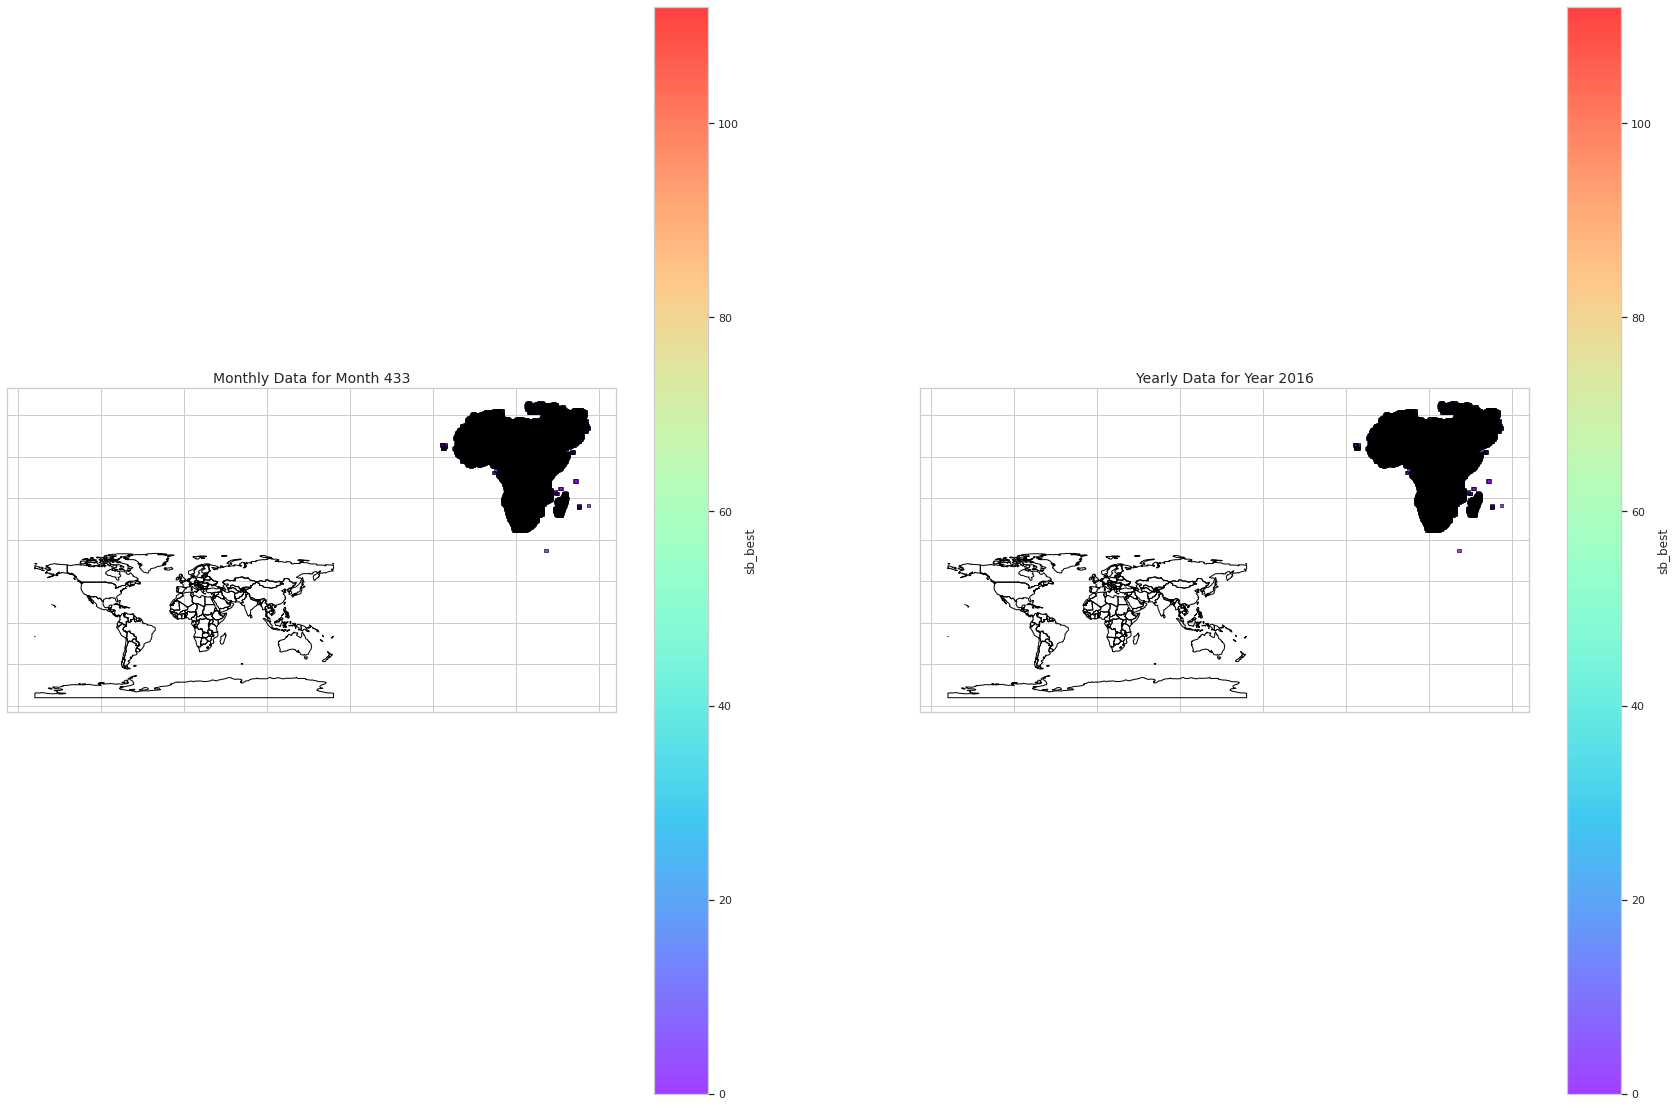

In [6]:
plot_random_monthly_and_yearly_data(df_monthly, df_yearly, feature = 'sb_best')

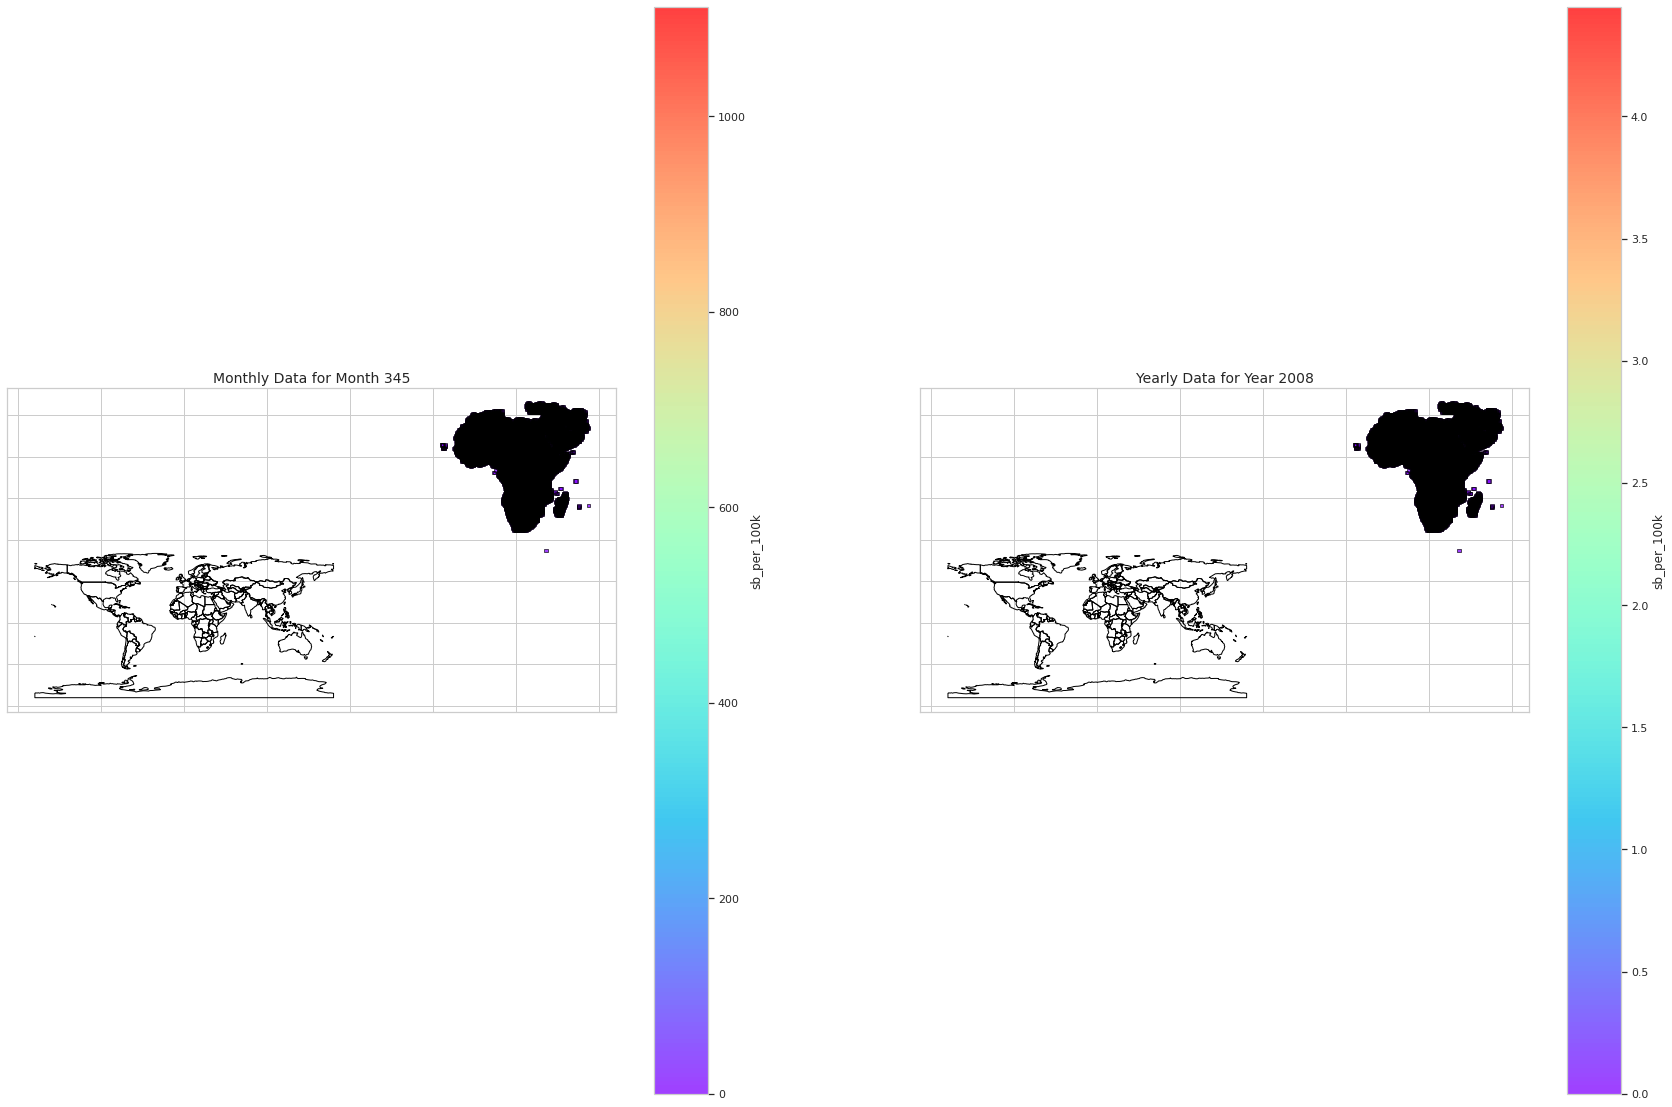

In [7]:
plot_random_monthly_and_yearly_data(df_monthly, df_yearly, feature = 'sb_per_100k')

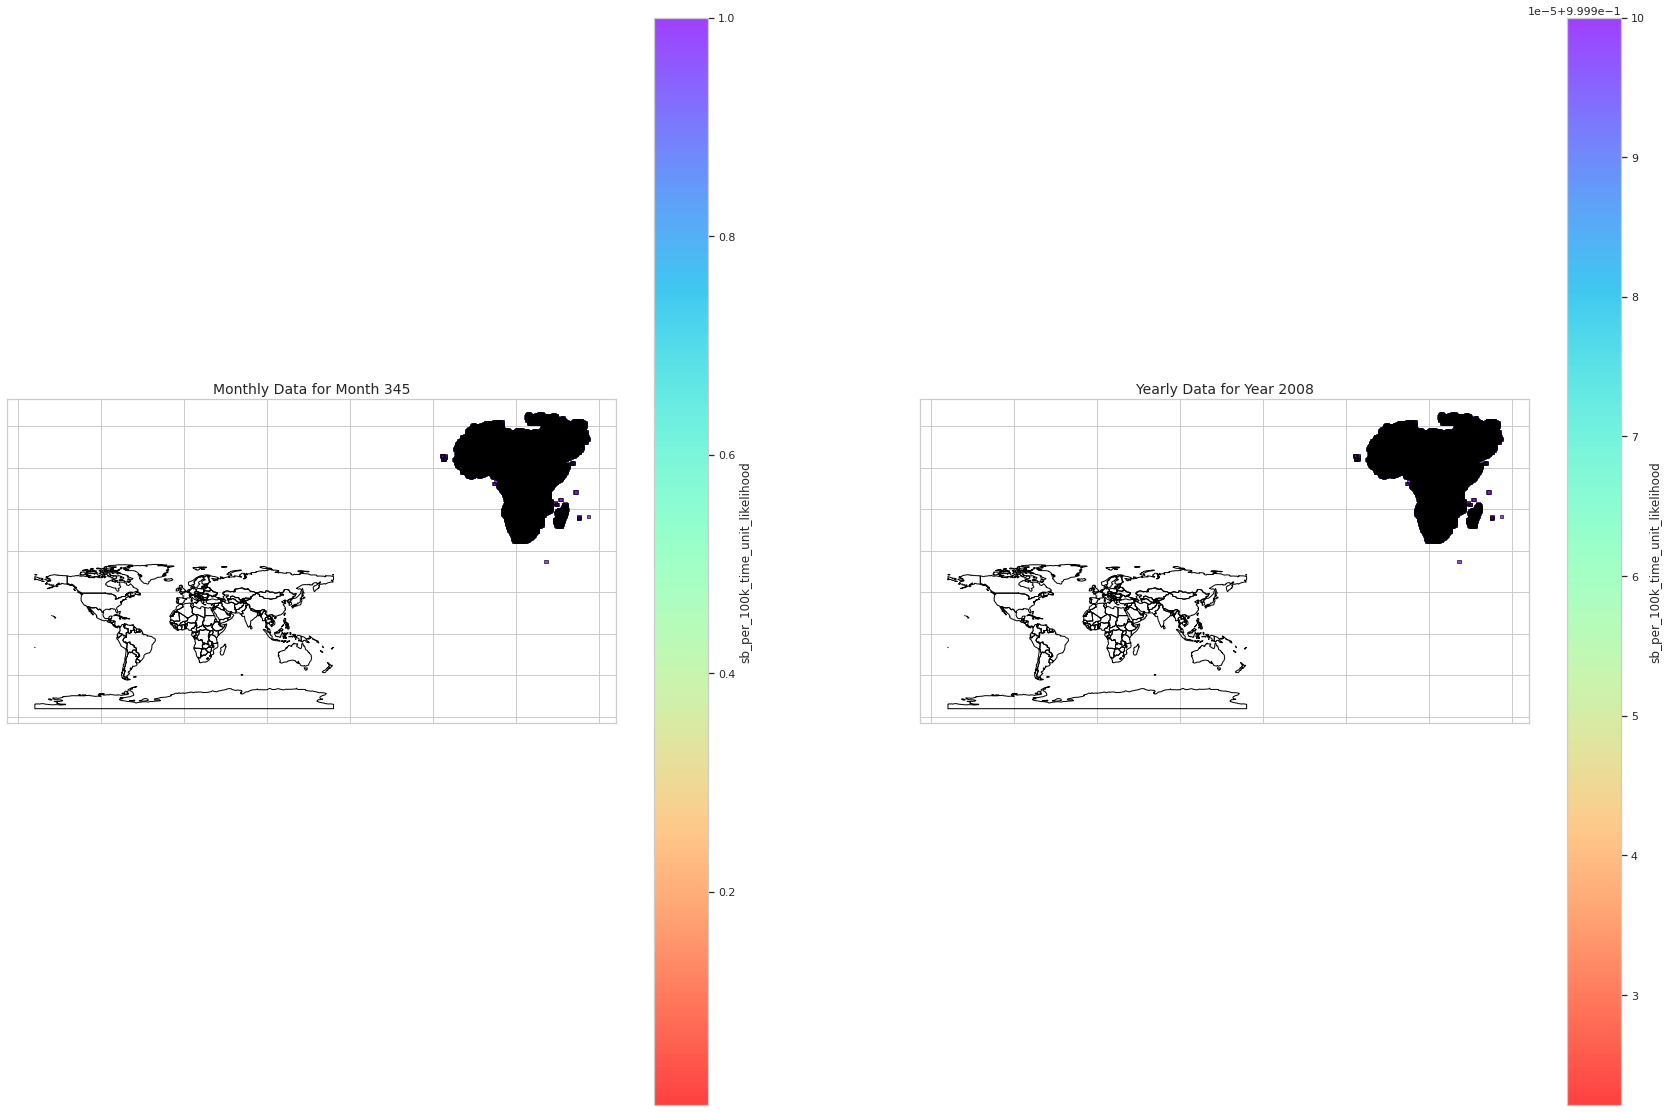

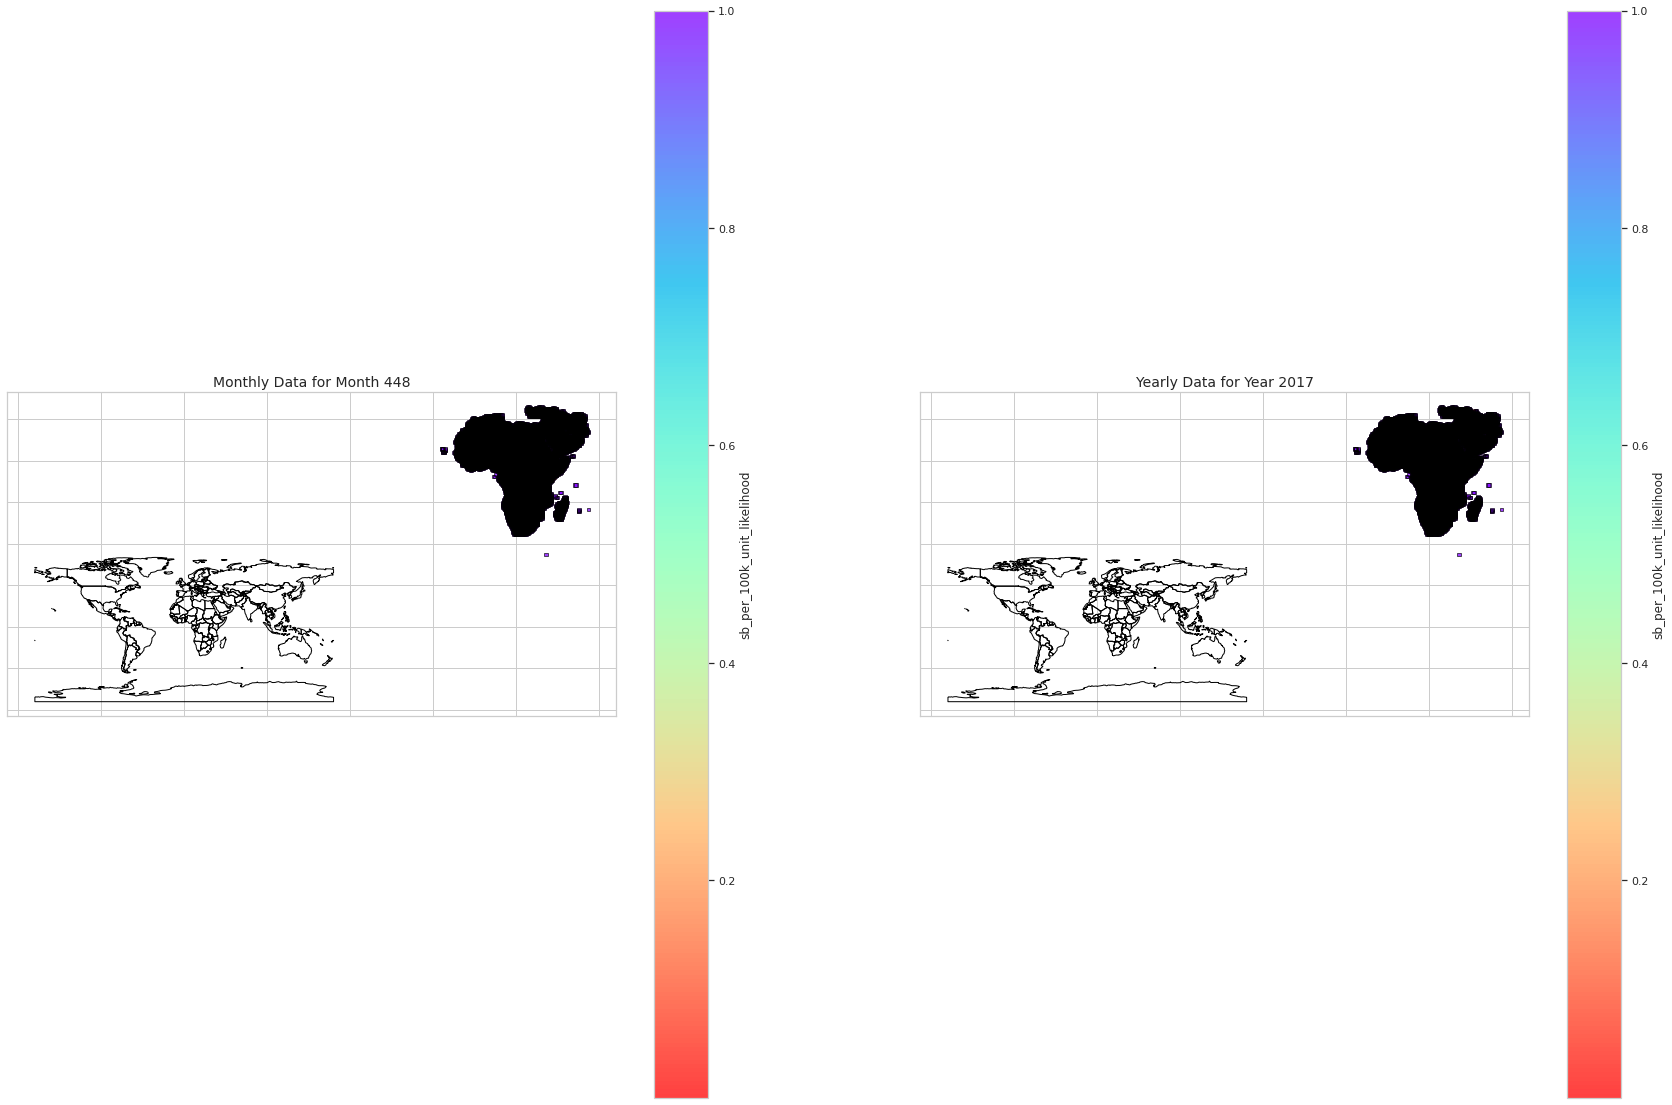

In [8]:
# plot the new global probabilities
plot_random_monthly_and_yearly_data(df_monthly, df_yearly, feature = 'sb_per_100k_time_unit_likelihood')
plot_random_monthly_and_yearly_data(df_monthly, df_yearly, feature = 'sb_per_100k_unit_likelihood')

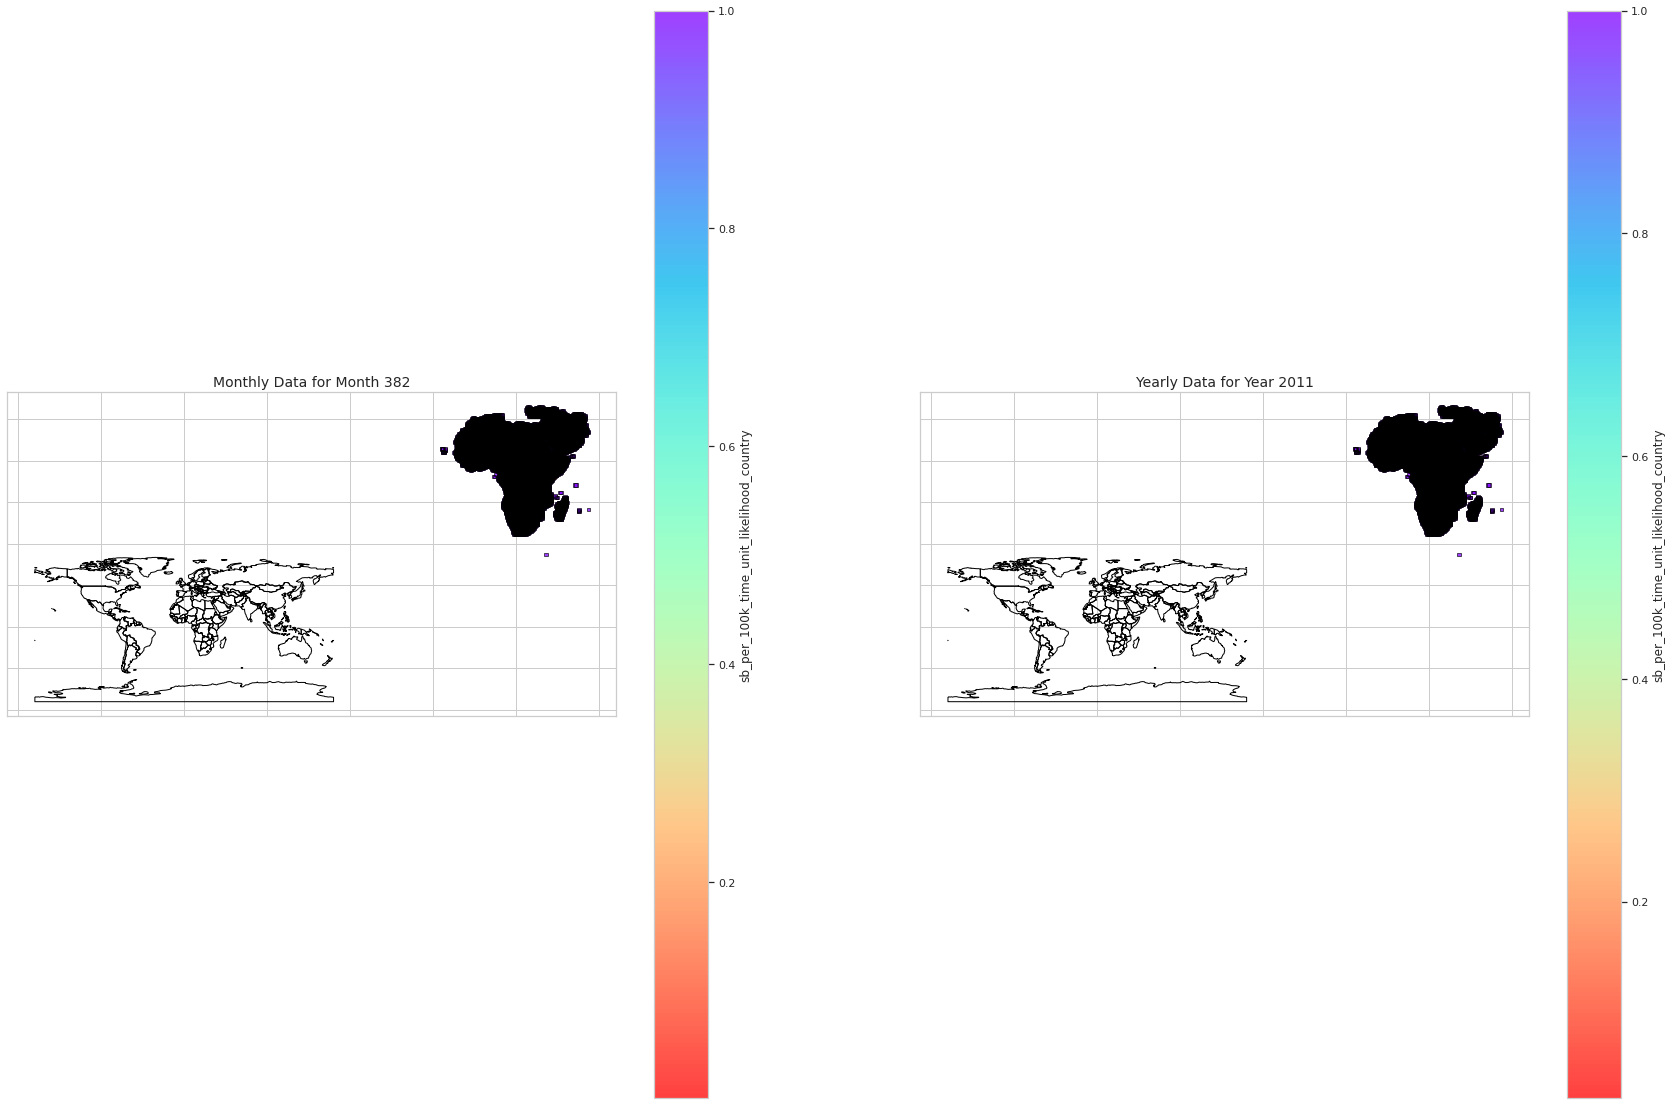

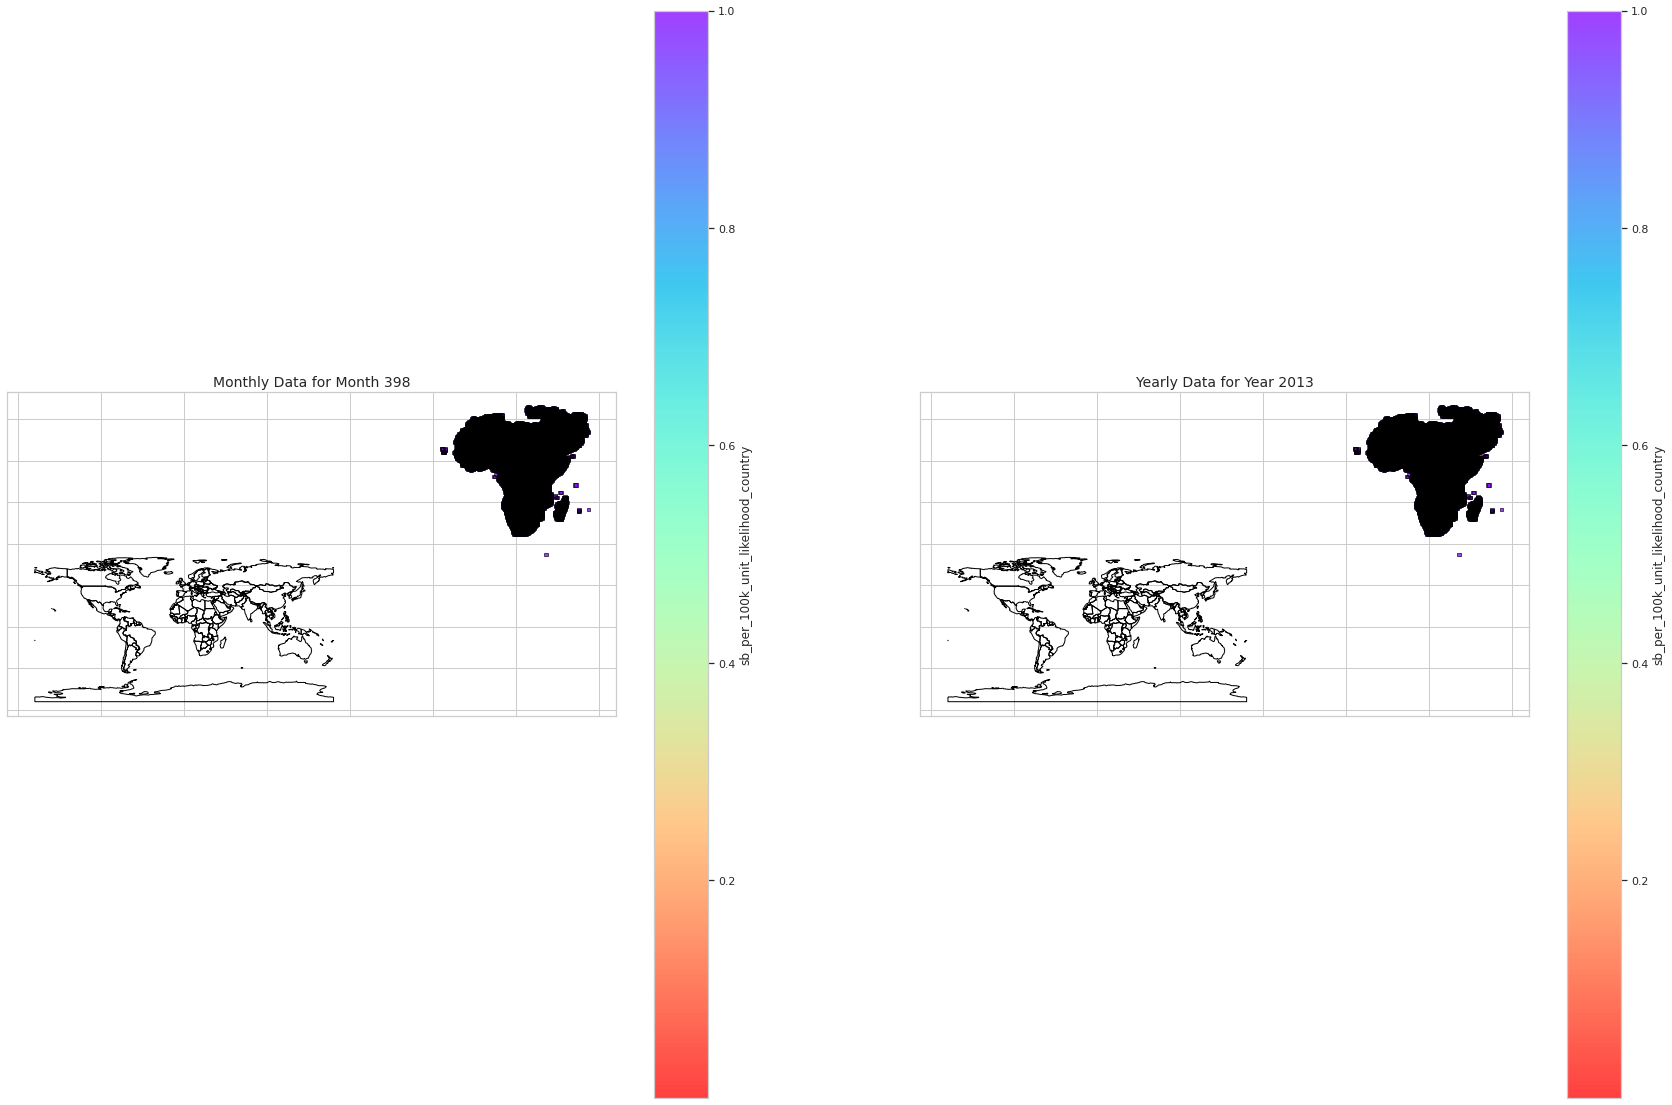

In [9]:
# plot the new country probabilities
plot_random_monthly_and_yearly_data(df_monthly, df_yearly, feature = 'sb_per_100k_time_unit_likelihood_country')
plot_random_monthly_and_yearly_data(df_monthly, df_yearly, feature = 'sb_per_100k_unit_likelihood_country')

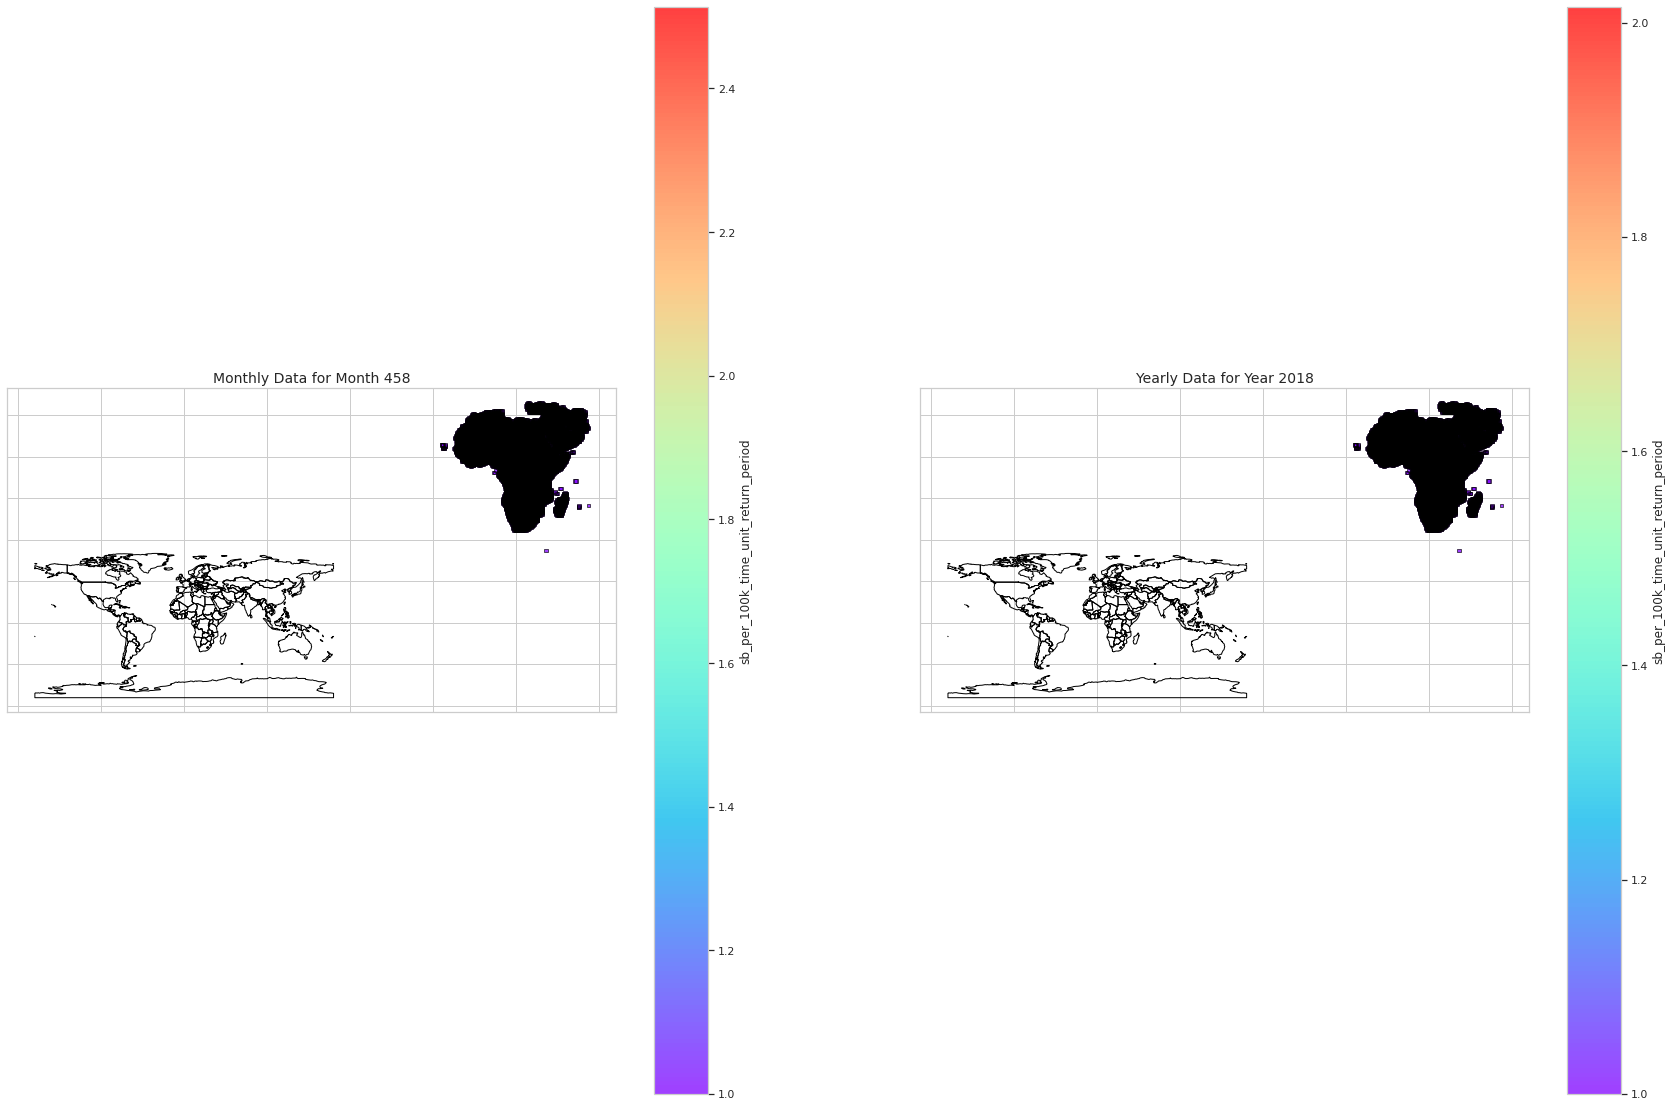

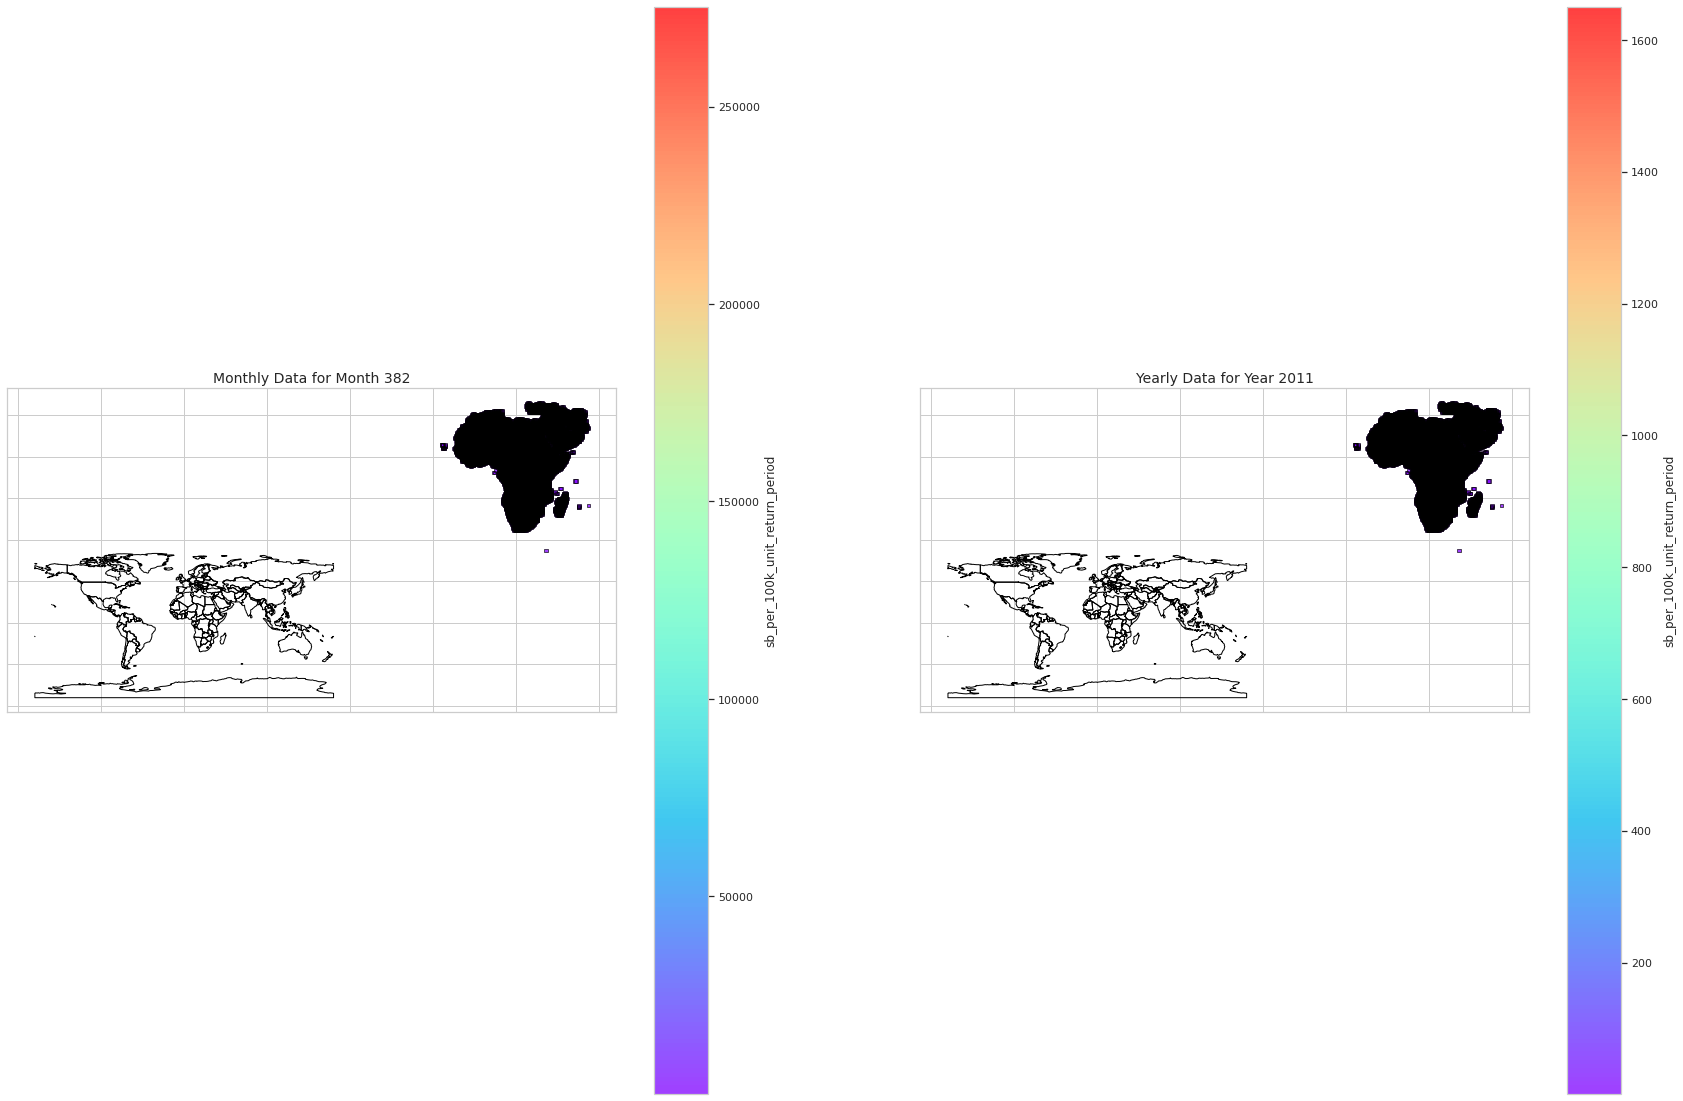

In [10]:
# some return periods
plot_random_monthly_and_yearly_data(df_monthly, df_yearly, feature = 'sb_per_100k_time_unit_return_period')
plot_random_monthly_and_yearly_data(df_monthly, df_yearly, feature = 'sb_per_100k_unit_return_period')

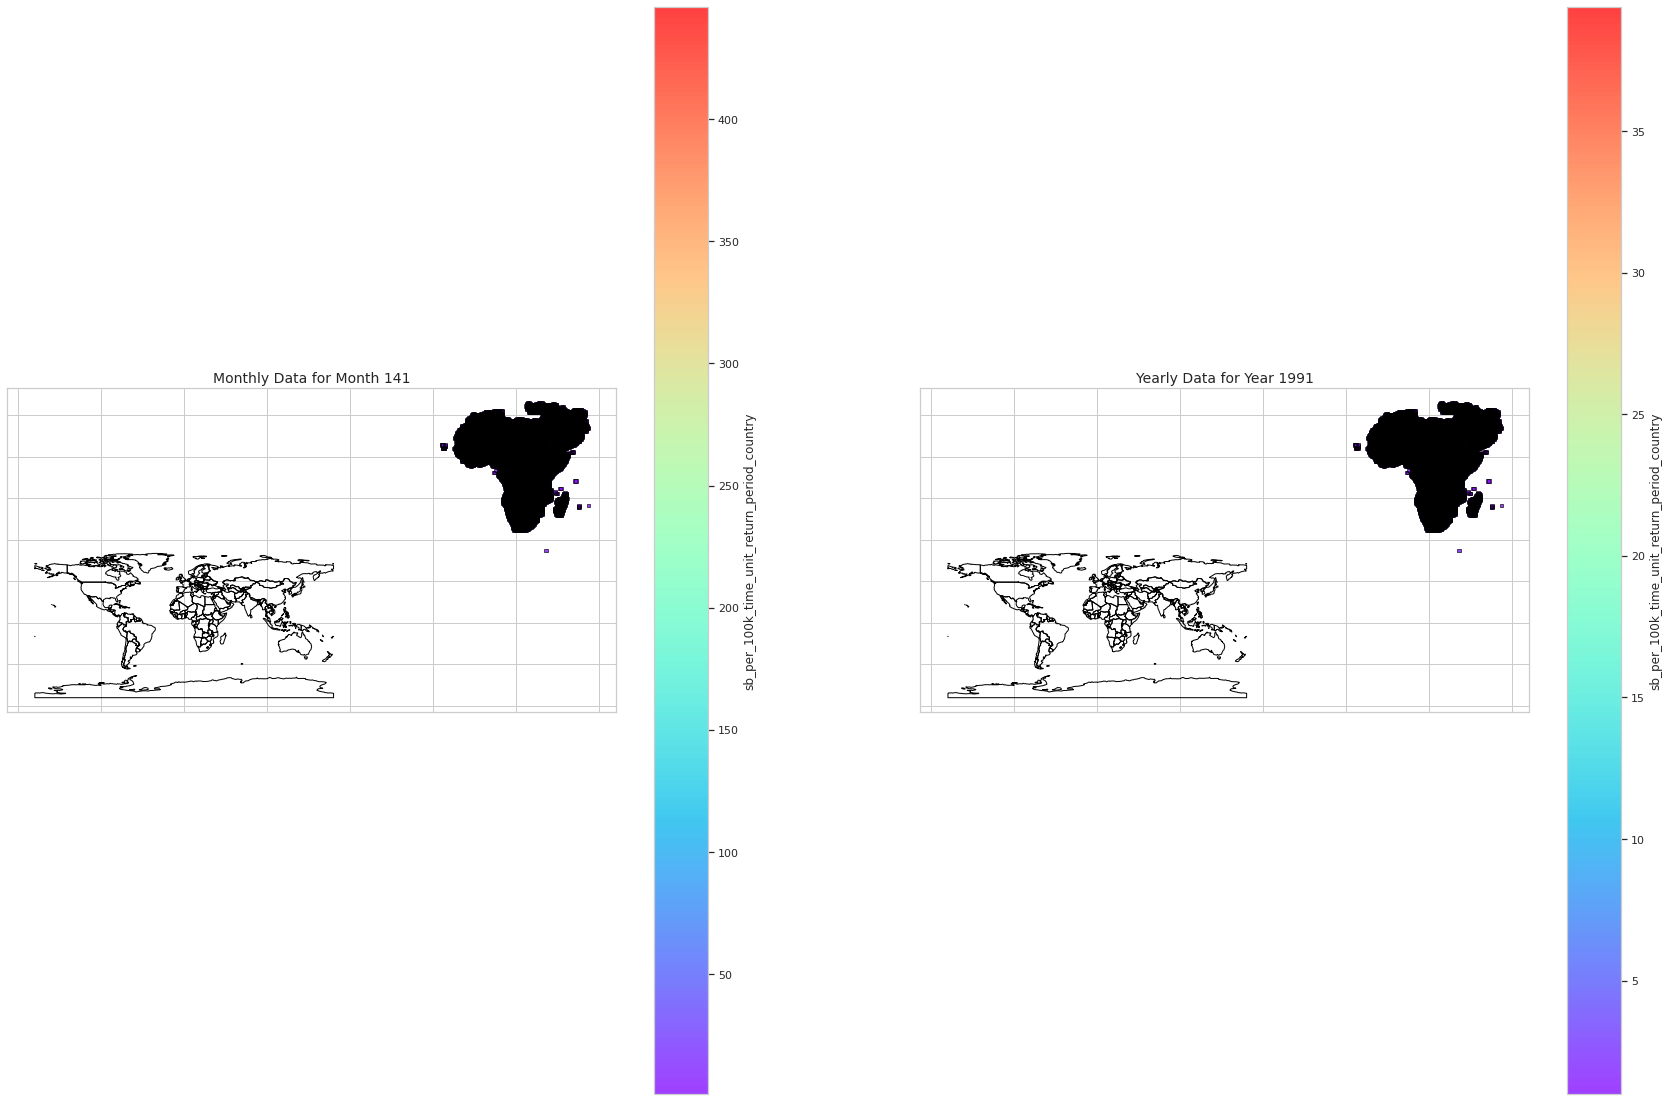

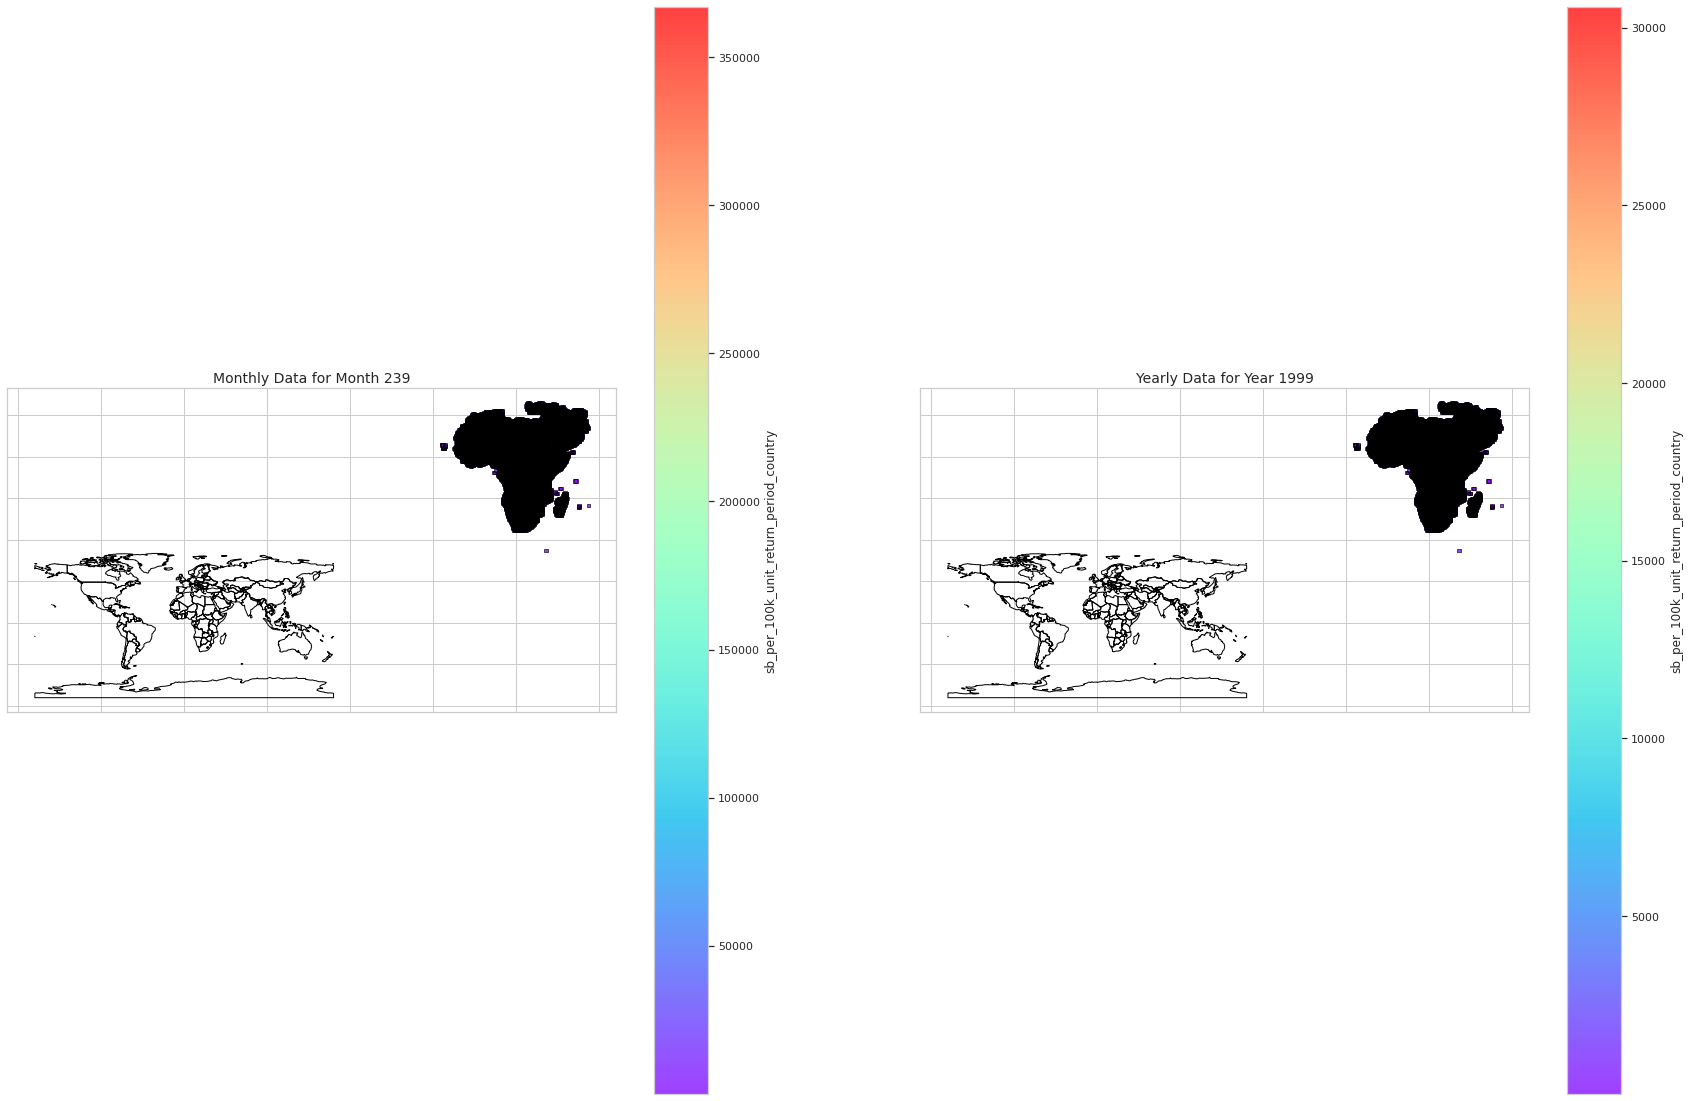

In [11]:
# some return periods at country level
plot_random_monthly_and_yearly_data(df_monthly, df_yearly, feature = 'sb_per_100k_time_unit_return_period_country')
plot_random_monthly_and_yearly_data(df_monthly, df_yearly, feature = 'sb_per_100k_unit_return_period_country')

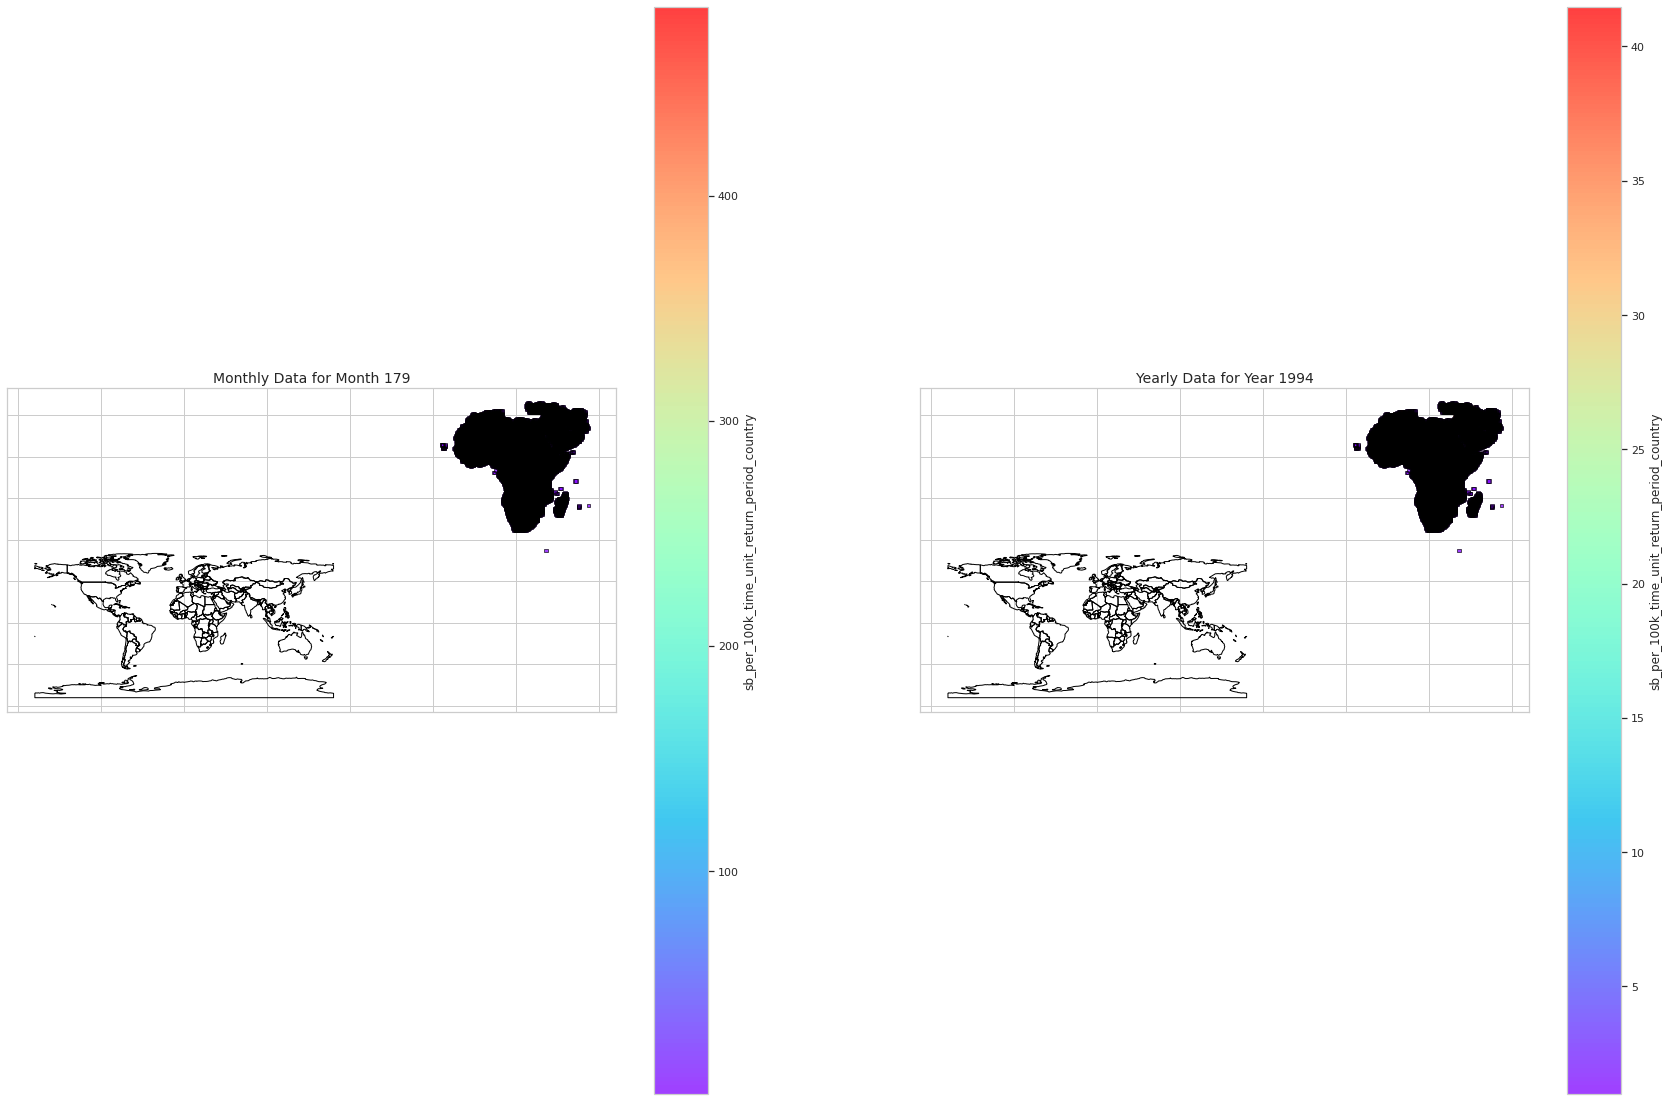

In [12]:
plot_random_monthly_and_yearly_data(df_monthly, df_yearly, feature = 'sb_per_100k_time_unit_return_period_country', year= 1994)

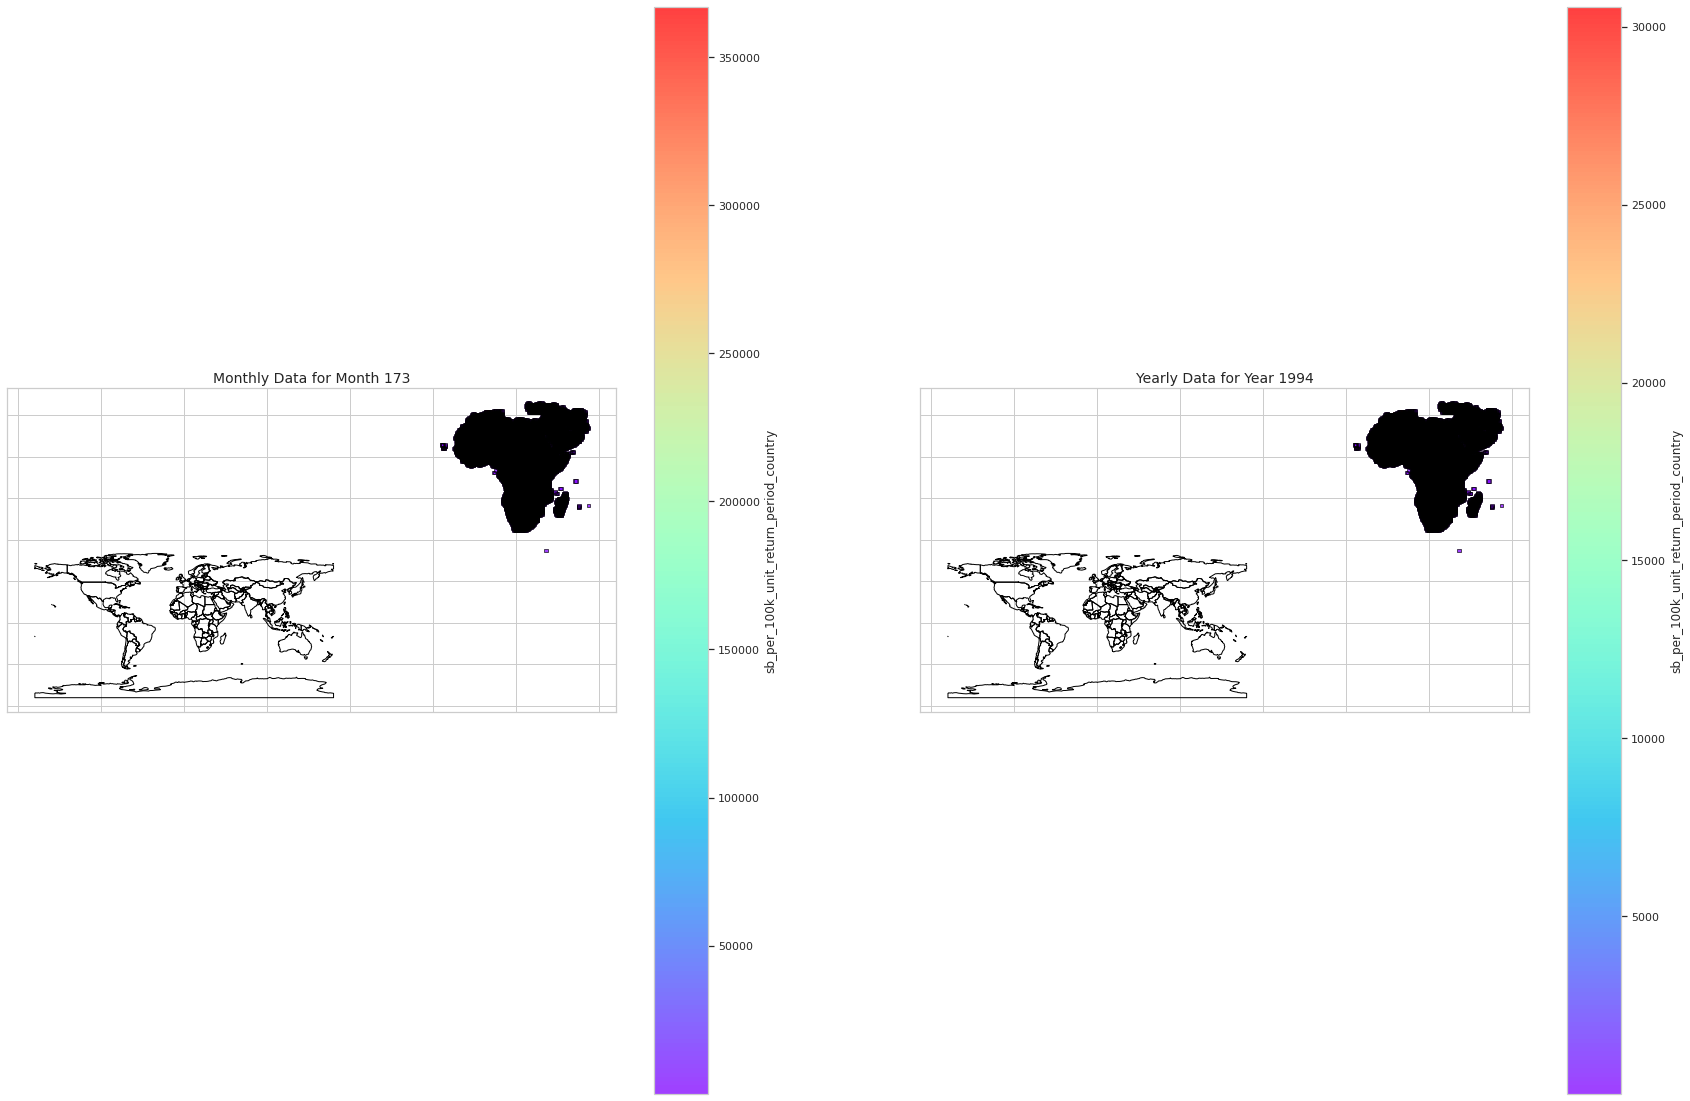

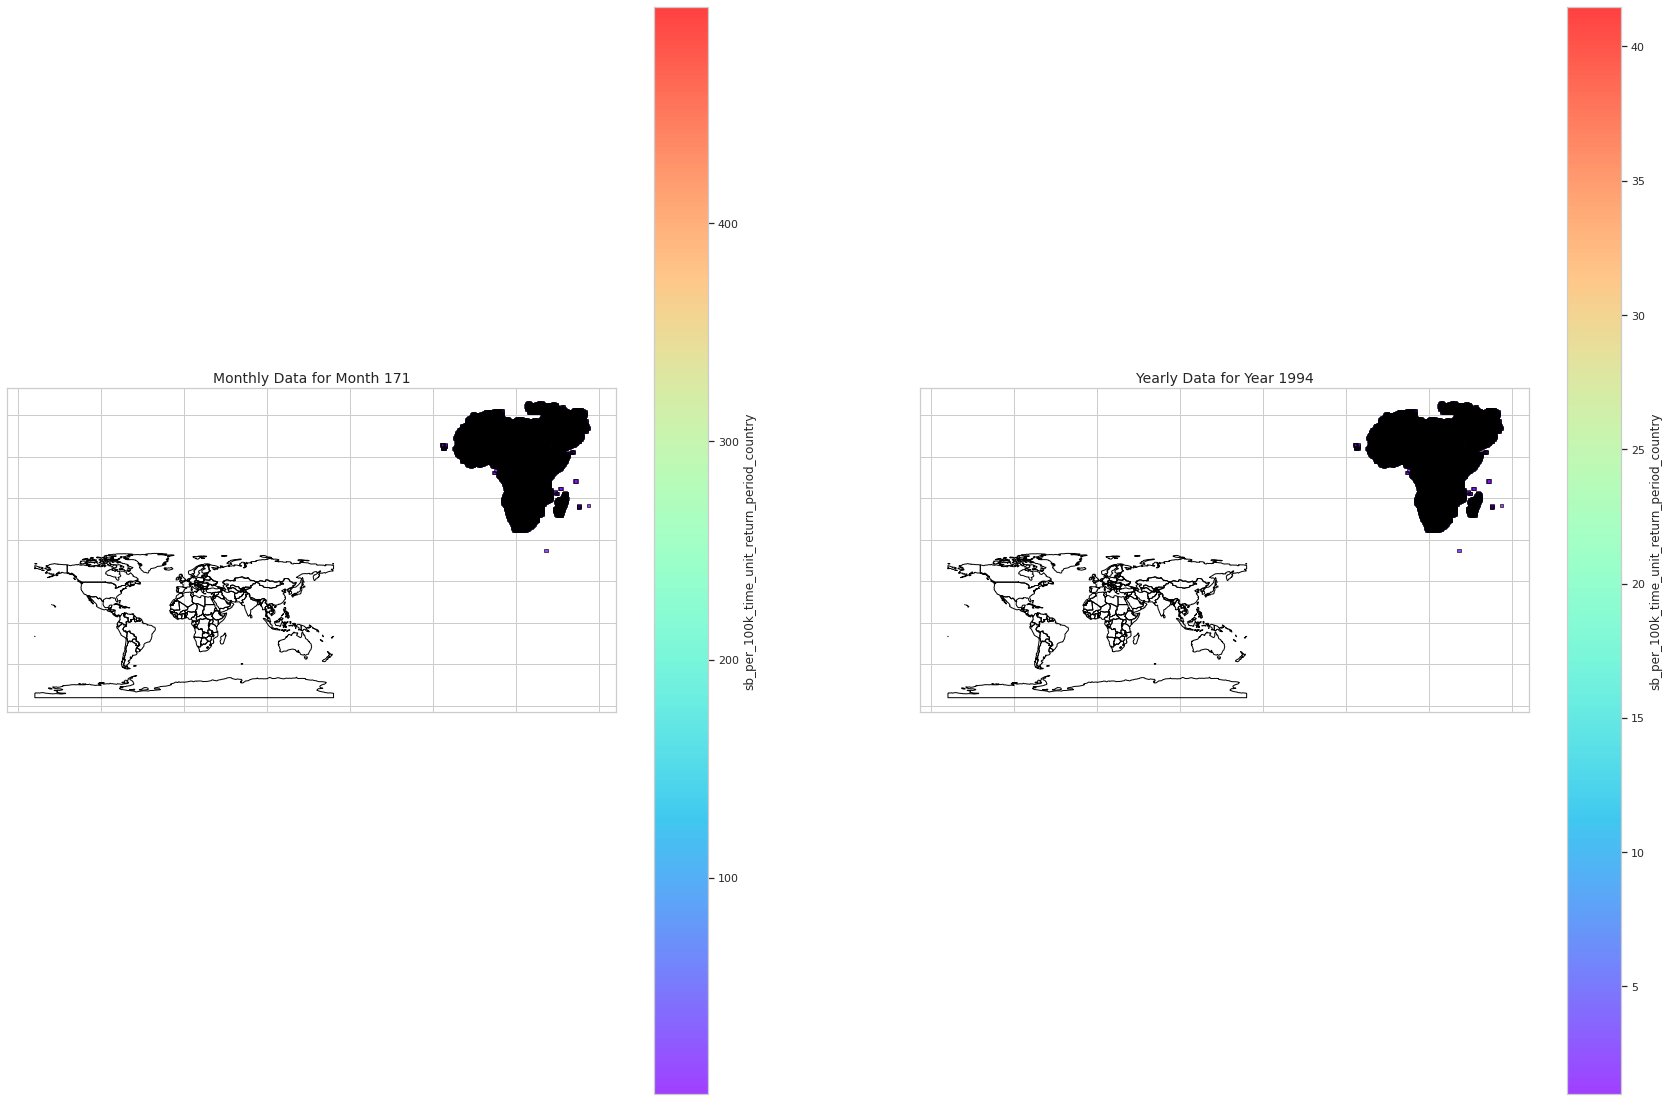

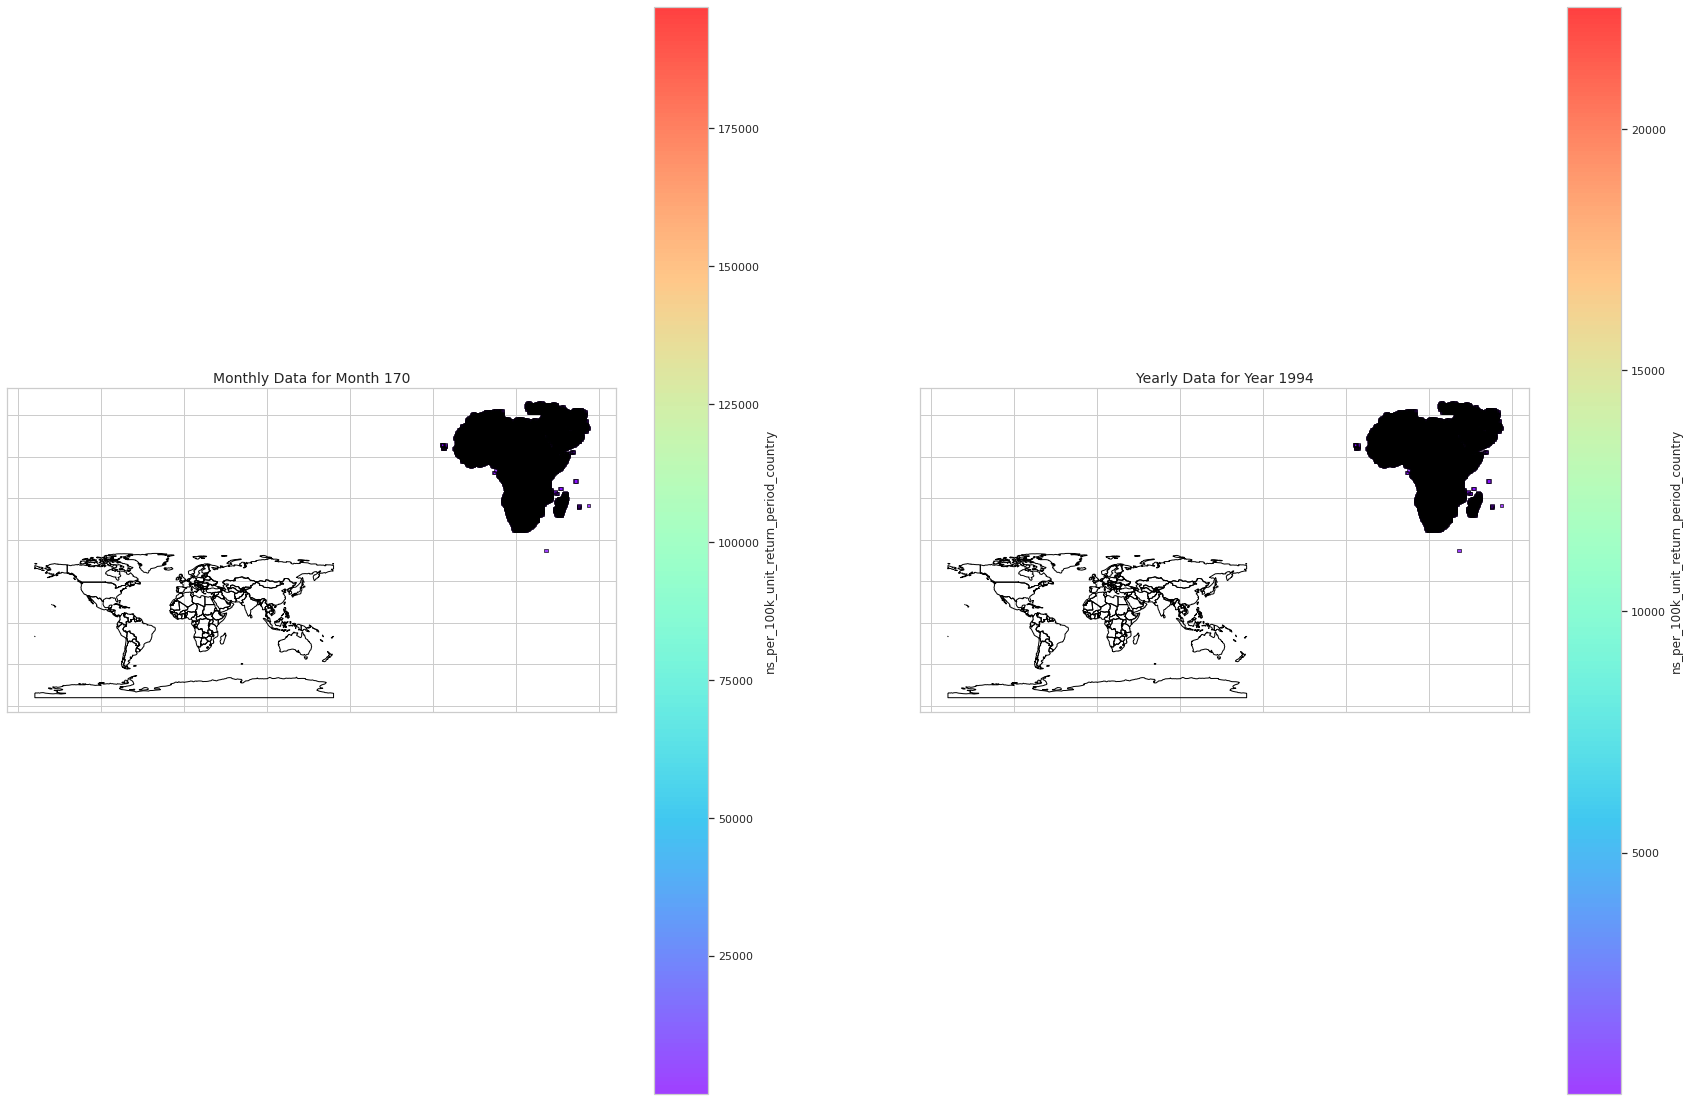

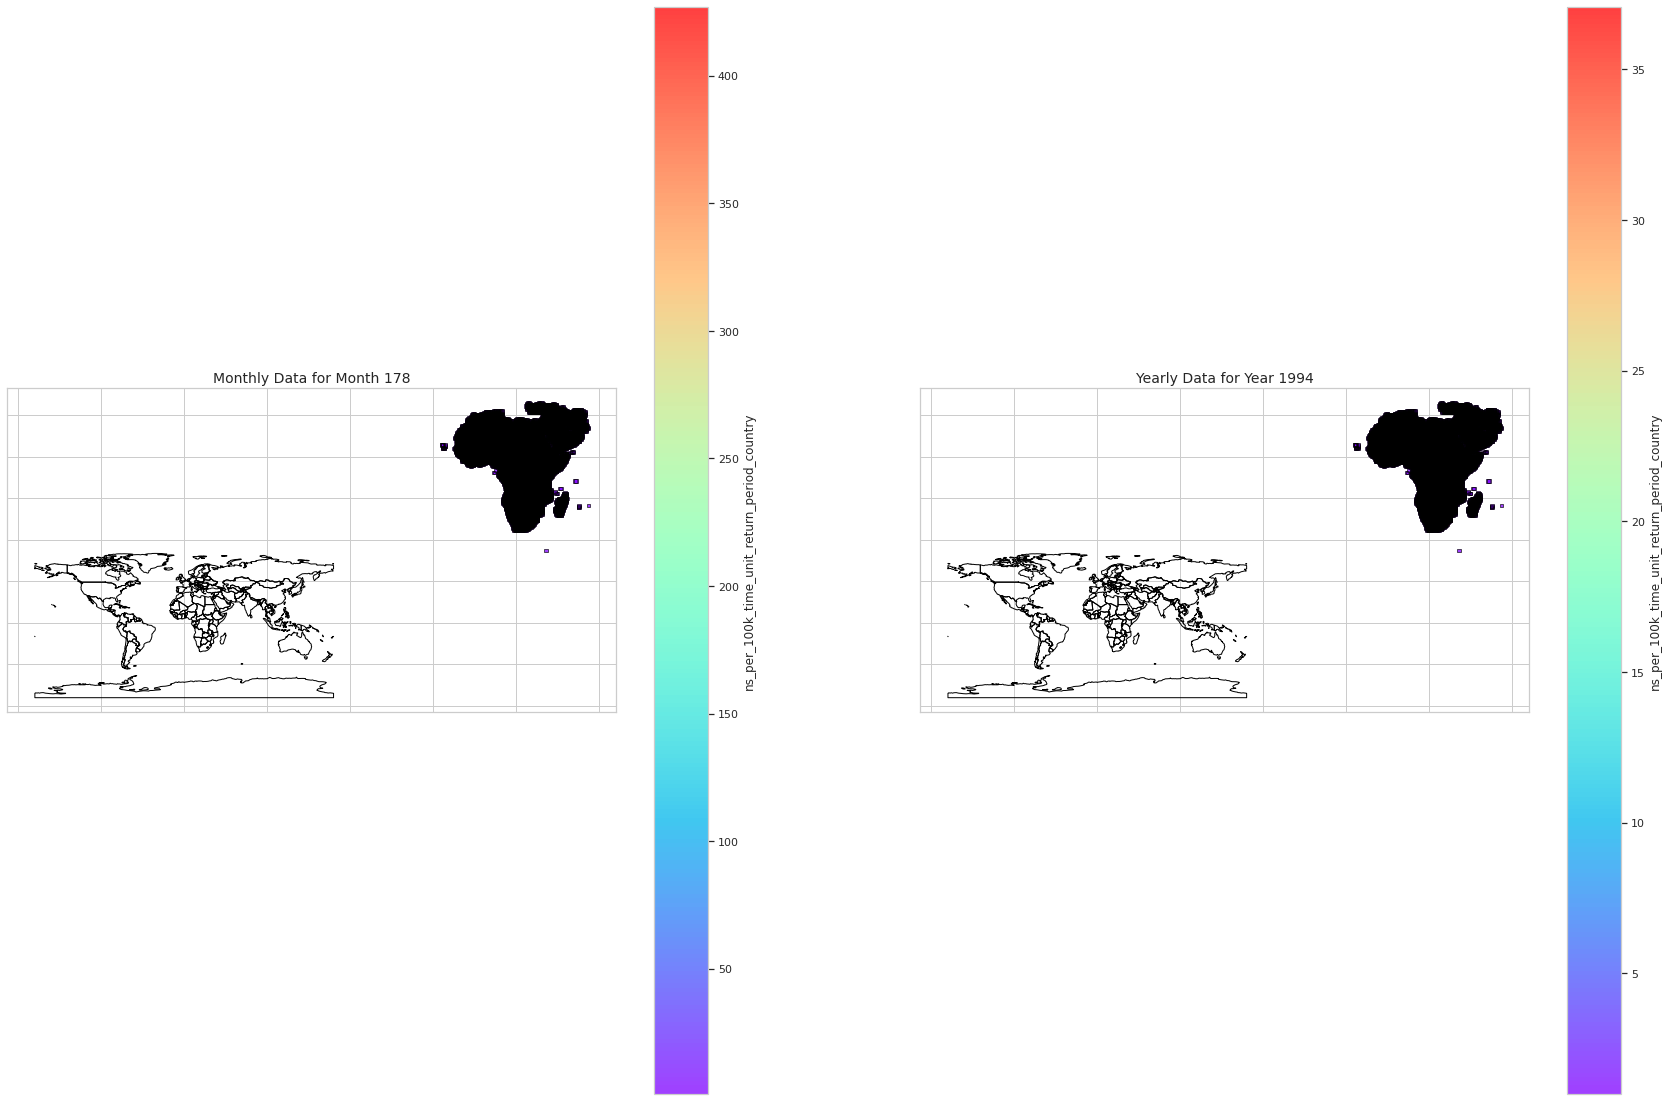

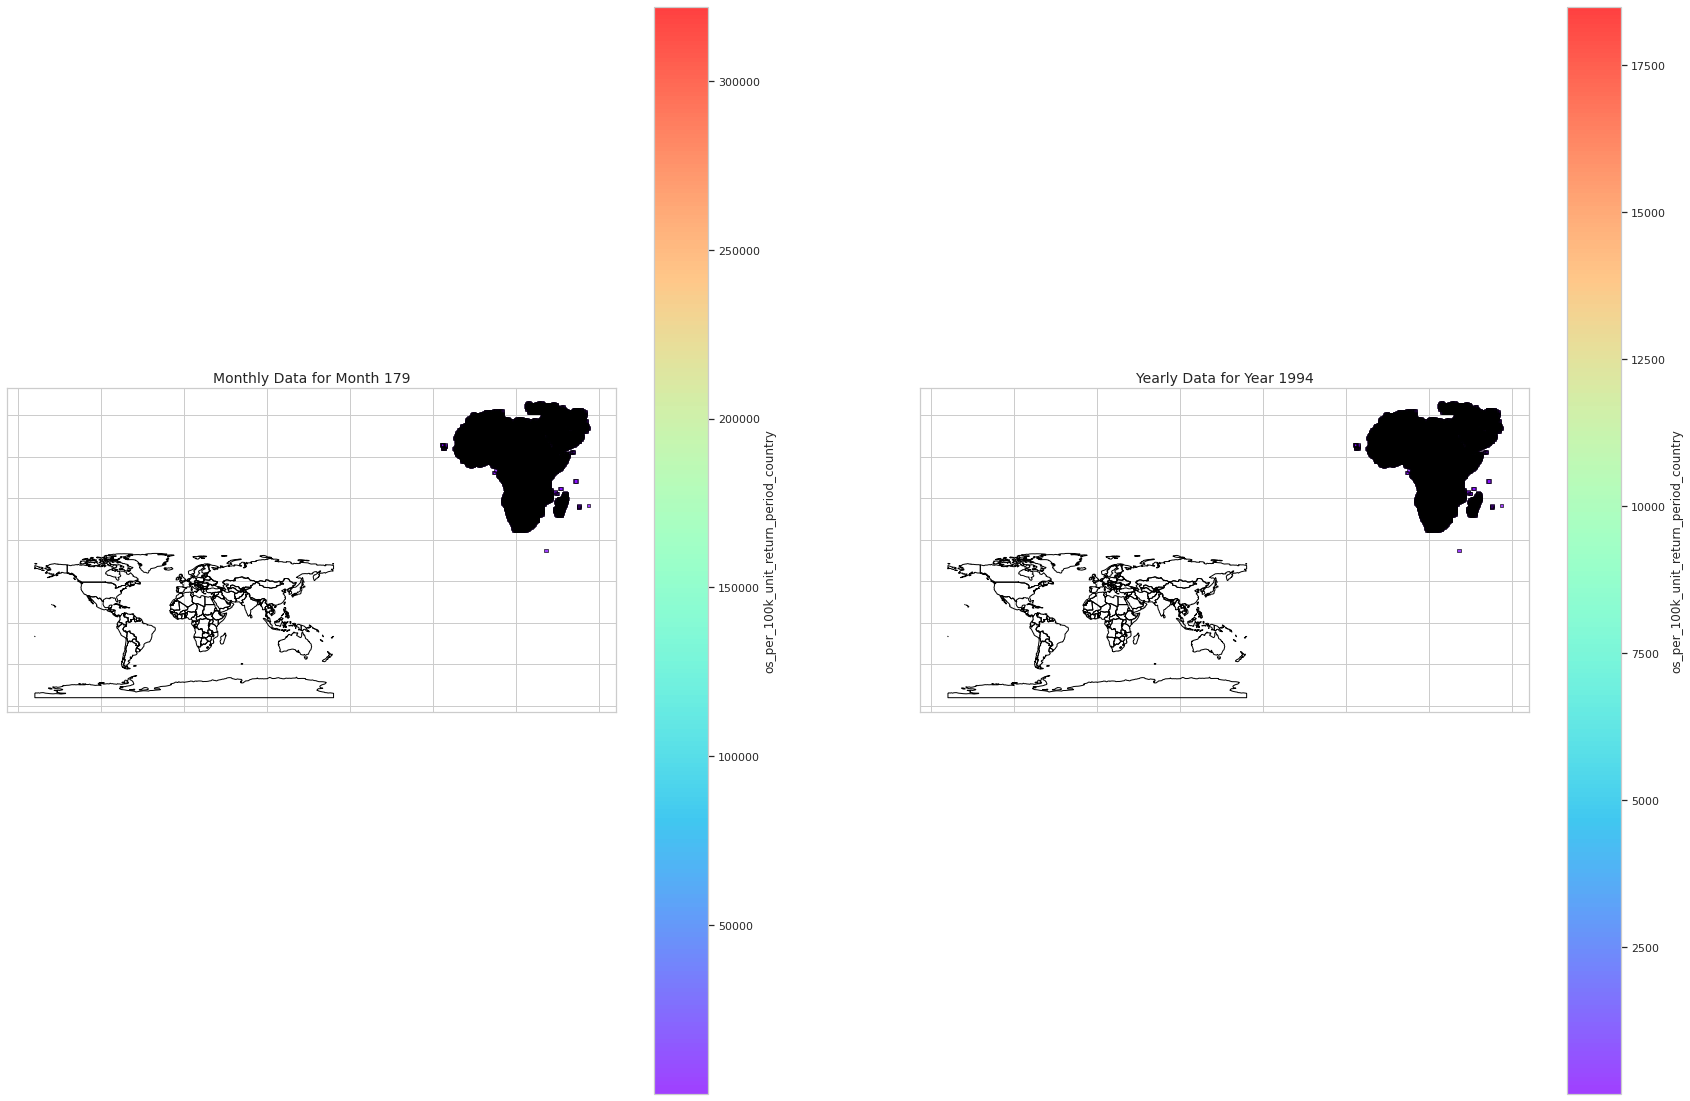

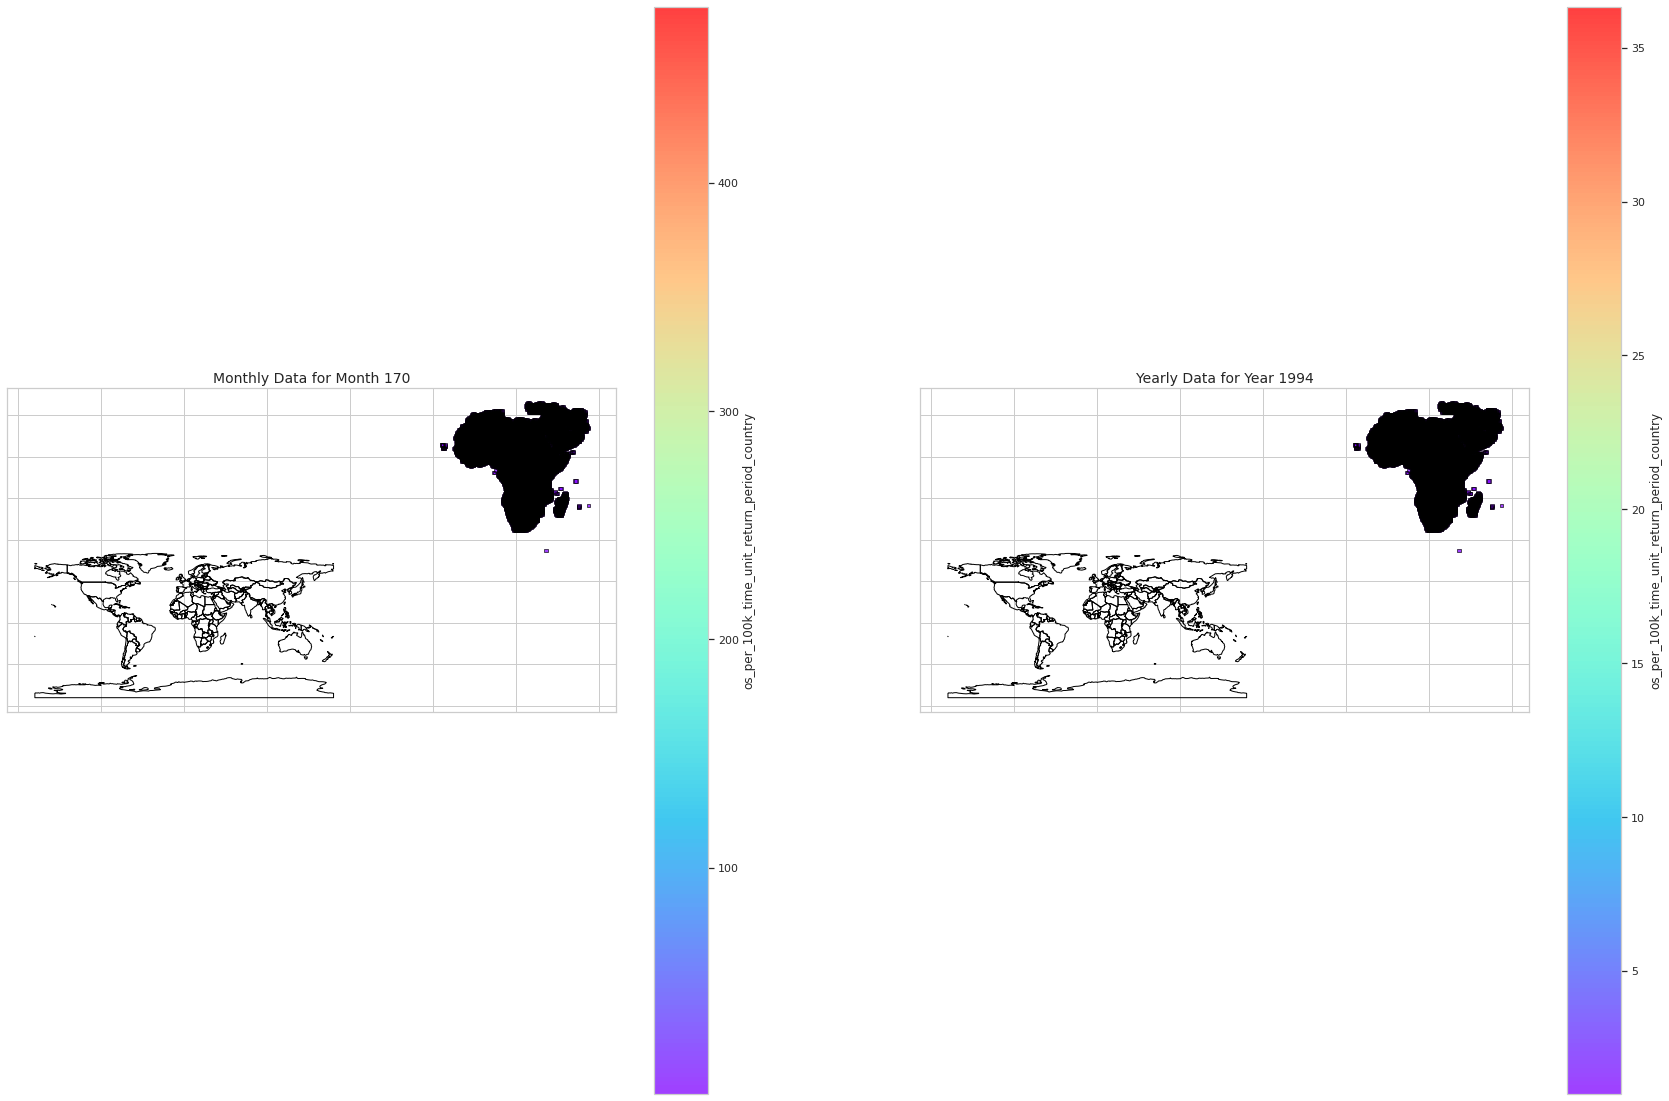

In [13]:
# plot all the "minimal features"

for feature in minimal_new_features:
    plot_random_monthly_and_yearly_data(df_monthly_minimal, df_yearly_minimal, feature = feature, year= 1994)

In [14]:
# load the minimal dataframes and check the expected feature agian
df_monthly_minimal_test = pd.read_pickle("/home/simon/Documents/scripts/VIEWS_FAO_index/data/processed/pilot_return_periods_monthly_minimal.pkl")
df_yearly_minimal_test = pd.read_pickle("/home/simon/Documents/scripts/VIEWS_FAO_index/data/processed/pilot_return_periods_yearly_minimal.pkl")

In [15]:
# save images from all features in the minimal dataframes given a year = 1914 and lock the month. 
for feature in minimal_new_features:
    plot_random_monthly_and_yearly_data(df_monthly_minimal_test, df_yearly_minimal_test, feature = feature, year= 1994, lock_first_month = True, save_plot = True)

TypeError: plot_random_monthly_and_yearly_data() got an unexpected keyword argument 'save_plot'

In [ ]:
# try to plot the minimal features - all the minimal features
for feature in minimal_new_features:
    for year in range(1989, 2023):
        plot_random_monthly_and_yearly_data(df_monthly_minimal_test, df_yearly_minimal_test, feature = feature, year= year)
